# UC Berkeley gender bias (Simpson's paradox)

The study of gender bias among graduate school admissions to UC Berkeley (fall of 1973) is one of the most well-known examples of Simpson's paradox. 

In [51]:
%matplotlib inline
import pandas as pd

import seaborn

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [22]:
flat_df = pd.read_csv('berkeley_case.csv', sep = ';')

In [23]:
total_stats = pd.pivot_table(flat_df, aggfunc = sum, index = 'gender', columns = 'status', values = 'number')
total_stats['perc_admitted'] = map(lambda x: round(x, 2), 100*total_stats.accepted/total_stats.applied) 
total_stats

status,accepted,applied,perc_admitted
gender,,,
men,1192,2590,46.02
women,557,1835,30.35


The admission figures showed that men applying were more likely than women to be admitted, and the difference was so large that it was unlikely to be due to chance. But let's investigate question a little big deeper and see percentage of admitted students by gender on different faculties. 

Pandas MultiIndex will be rather handy for this task. The most common way to create a DataFrame with multi-index is to make it with pivot_table.

In [30]:
df = pd.pivot_table(flat_df, index = 'faculty', values = 'number', columns = ['status', 'gender'])
df

status  accepted       applied      
gender       men women     men women
faculty                             
A            512    89     825   108
B            353    17     560    25
C            120   202     325   593
D            138   131     417   375
E             53    94     191   393
F             16    24     272   341

In [31]:
# first of all we calculate the admission rates by gender as separate df
admitted_perc = (100*df['accepted']/df['applied']).applymap(lambda x: round(x, 2))
admitted_perc

gender,men,women
faculty,,
A,62.06,82.41
B,63.04,68.00
C,36.92,34.06
D,33.09,34.93
E,27.75,23.92
F,5.88,7.04


In [26]:
# now we need to add one more level to df 
admitted_perc = admitted_perc.T
admitted_perc['status'] = 'perc_admitted'
admitted_perc.set_index('status', append = True, inplace = True)
admitted_perc

,faculty,A,B,C,D,E,F
gender,status,,,,,,
men,perc_admitted,62.06,63.04,36.92,33.09,27.75,5.88
women,perc_admitted,82.41,68.00,34.06,34.93,23.92,7.04


In [27]:
admitted_perc = admitted_perc.reorder_levels(['status', 'gender'])
admitted_perc

faculty                   A      B      C      D      E     F
status        gender                                         
perc_admitted men     62.06  63.04  36.92  33.09  27.75  5.88
              women   82.41  68.00  34.06  34.93  23.92  7.04

In [28]:
# concatenate initial df with admission rate df
df = pd.concat([df.T, admitted_perc])
df = df.reorder_levels(['gender', 'status']).sort_index(level = 0).T
df

gender       men                          women                      
status  accepted applied perc_admitted accepted applied perc_admitted
faculty                                                              
A          512.0   825.0         62.06     89.0   108.0         82.41
B          353.0   560.0         63.04     17.0    25.0         68.00
C          120.0   325.0         36.92    202.0   593.0         34.06
D          138.0   417.0         33.09    131.0   375.0         34.93
E           53.0   191.0         27.75     94.0   393.0         23.92
F           16.0   272.0          5.88     24.0   341.0          7.04

We saw that on most faculties women are more likely to be admitted, on faculties C and E women's admission rate is a bit smaller than men's (but difference is small and it can be just by chance). So it's a bit confusing: on total values we saw the big difference between women's and men's admission, but the situation is opposite when we are looking at admission rates by faculty (that's Simpson's paradox).
 
The cause it that women tended to apply to competitive departments with low rates of admission even among qualified applicants (such as in the English Department), whereas men tended to apply to less-competitive departments with high rates of admission among the qualified applicants (such as in engineering and chemistry). 
Let's investigate it.

First of all, let's calculate average admission rates for faculties

In [43]:
faculty_admitted_perc = pd.pivot_table(flat_df, aggfunc = sum, index = 'faculty', 
                                       columns = 'status', values = 'number')
faculty_admitted_perc['total_perc_admitted'] = 100*faculty_admitted_perc.accepted/faculty_admitted_perc.applied
faculty_admitted_perc

status,accepted,applied,total_perc_admitted
faculty,,,
A,601,933,64.415863
B,370,585,63.247863
C,322,918,35.076253
D,269,792,33.964646
E,147,584,25.171233
F,40,613,6.525285


Then let's calculate the number of aplications by faculties for different genders. 

In [46]:
gender_faculty_applications = pd.pivot_table(flat_df[flat_df['status'] == 'applied'], 
                                             index = 'faculty', values = 'number', columns = 'gender')
gender_faculty_applications = gender_faculty_applications.apply(lambda x: 100*x/gender_faculty_applications.sum(), axis = 1)
gender_faculty_applications.columns = map(lambda x: x + '_faculty_share', gender_faculty_applications.columns)
gender_faculty_applications

,men_faculty_share,women_faculty_share
faculty,,
A,31.853282,5.885559
B,21.621622,1.362398
C,12.548263,32.316076
D,16.100386,20.435967
E,7.374517,21.416894
F,10.501931,18.583106


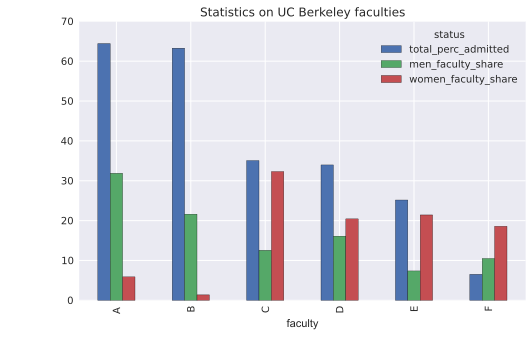

In [54]:
faculty_stats = faculty_admitted_perc[['total_perc_admitted']].join(gender_faculty_applications)
faculty_stats.plot(kind = 'bar', title = 'Statistics on UC Berkeley faculties')